####  MICCAI_BraTS_2018_Data 数据集说明

- BraTS 数据集是脑肿瘤分割比赛数据集，brats 2018中的训练集( training set) 有285个病例，每个病例有四个模态(t1、t2、flair、t1ce)，需要分割三个部分：whole tumor(WT), enhance tumor(ET), and tumor core(TC)

- t1、t2、flair、t1ce可以理解为核磁共振图像的四个不同纬度信息，每个序列的图像shape为（155,240,240）

- 目标是分割出三个label。对应医学中的三个不同肿瘤类型

#### 数据集介绍
BraTs数据集类型为XX.nii.gz，分别对应t1、t2、flair、t1ce，seg，其中seg是分割图像。图像大小均为（155，240，240）

## 提取数据

In [1]:
import zipfile 
dataset_path = "./data/MICCAI_BraTS_2018_Data_Training.zip"  # Replace with your dataset path
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()
print("提取数据成功")

提取数据成功


## 安装依赖

In [2]:
# venv
# !python3 -m venv venv
# !source venv/bin/active
# !pip install -r requirements.txt

# conda
!conda env create -f enviroment.yml



CondaValueError: prefix already exists: /Users/zhi/opt/anaconda3/envs/tf_36



In [22]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)
from tqdm import tqdm

## 数据预处理

In [2]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)

def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std

def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ncr, ed, et], dtype=np.uint8)

## 加载数据

In [3]:
# Get a list of files for all modalities individually
t1 = glob.glob('*GG/*/*t1.nii.gz')
t2 = glob.glob('*GG/*/*t2.nii.gz')
flair = glob.glob('*GG/*/*flair.nii.gz')
t1ce = glob.glob('*GG/*/*t1ce.nii.gz')
seg = glob.glob('*GG/*/*seg.nii.gz')  # Ground Truth

In [4]:
pat = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

## 装载数据到 Numpy 数组

In [27]:
input_shape = (4, 80, 96, 64)
output_channels = 3
data = np.empty((len(data_paths[:4]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[:4]), output_channels) + input_shape[1:], dtype=np.uint8)

In [28]:
total = len(data_paths[:4])

for i, imgs in tqdm(enumerate(data_paths[:4]),desc="load data",total=total):
    data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
    labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]

load data: 100%|██████████| 4/4 [00:14<00:00,  3.62s/it]


## 构建模型

In [29]:
print(data[0].shape)
print(labels[0].shape)

(4, 80, 96, 64)
(3, 80, 96, 64)


## 展示图片

HGG/Brats18_CBICA_AOO_1/Brats18_CBICA_AOO_1_seg.nii.gz
(240, 240)
[0 1]
1055
2


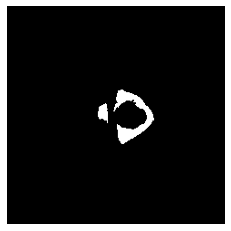

In [30]:
import matplotlib.pyplot as plt
print(seg[0])
img = (read_img(seg[0])[100] == 2).astype(np.uint8)
print(img.shape)
print(np.unique(img))
print(img.sum())
print(np.asanyarray(img).ndim)
plt.axis('off')
plt.imshow(img,cmap='Greys_r')